In [1]:
import random
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from copy import deepcopy
from typing import Dict, List, Tuple

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker

In [3]:
# Load DCIts
import sys
import os
sys.path.append('..')
from src.dcits import DCITS

In [4]:
# Load utils
from src.utils import *

In [5]:
# Set random seeds for reproducibility
seed = 1000

In [6]:
# Check if CUDA is available
if torch.cuda.is_available():
    # Specify the device (index starts from 0, so cuda:0 is the first GPU)
    device = torch.device("cuda:0")
    print(f"Using {torch.cuda.get_device_name(device)}")
else:
    print("CUDA is not available. Using CPU instead.")
    device = torch.device("cpu")

Using NVIDIA RTX A4000


## Data generation parameters

In [7]:
mean = 0
std = 0.1
frequency = 0.3
ts_length = 20000
burn_in = 1000

# Dataset 4

The dataset is defined by the following equations:

$$
\begin{split}
X_{1,t} &= \alpha^\text{gt}_{1,2,l} X_{2,t-l} + \epsilon_{1,t}, \\
X_{2,t} &= \alpha^\text{gt}_{2,1,l} X_{1,t-l} + \epsilon_{2,t}.
\end{split}
$$

The ground-truth coefficients are specified as:

$$
\begin{array}{l}
\alpha^\text{gt}_{1,2,2} = \alpha^\text{gt}_{1,2,9} = \frac{2}{5}, \quad 
\alpha^\text{gt}_{1,2,5} = \frac{1}{5}, \\
\alpha^\text{gt}_{2,1,2} = \alpha^\text{gt}_{2,1,9} = \frac{2}{5}, \quad 
\alpha^\text{gt}_{2,1,5} = \frac{1}{5}.
\end{array}
$$

In [8]:
dataset_name="Dataset 4"

In [9]:
# gp = generating process
no_of_timeseries_gp = 2
window_length_gp = 9

# Define deterministic ground truth alpha coefficients
ground_truth_alpha = torch.zeros(no_of_timeseries_gp, no_of_timeseries_gp, window_length_gp)
ground_truth_alpha[0, 1, 1] = 2/5
ground_truth_alpha[0, 1, 4] = 1/5
ground_truth_alpha[0, 1, 8] = 2/5
ground_truth_alpha[1, 0, 1] = 2/5
ground_truth_alpha[1, 0, 4] = 1/5
ground_truth_alpha[1, 0, 8] = 2/5

# Create a mask with the same shape as ground_truth_alpha (can be usefull in analysis)
alpha_mask = (ground_truth_alpha != 0).float()  # 1 where there's a non-zero value, 0 otherwise

# How to apply mask to the alpha tensor
# masked_alpha = ground_truth_alpha * alpha_mask

# Create bias tensor
ground_truth_bias = torch.zeros(no_of_timeseries_gp)

In [10]:
beta_tilde = torch.abs(ground_truth_alpha).sum(axis=-1)

# Compute beta and beta_std
ground_truth_beta = beta_tilde / beta_tilde.sum(1,keepdims=True)  # Normalize beta_tilde
ground_truth_beta

tensor([[0., 1.],
        [1., 0.]])

In [11]:
time_series = dataset(ts_length, ground_truth_alpha, 
                           ground_truth_bias, noise_frequency=frequency, 
                           mu=mean, sigma=std, seed=seed)
time_series.shape

torch.Size([2, 20000])

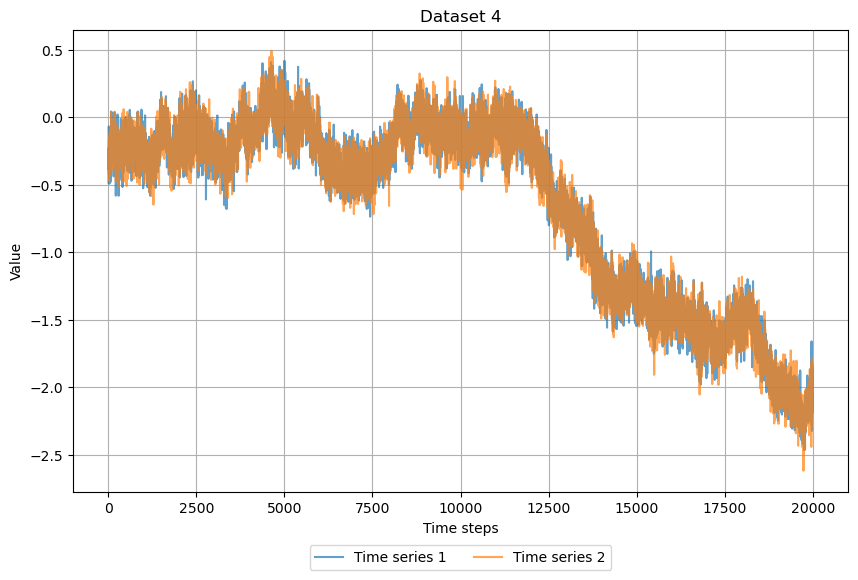

In [12]:
plot_ts(time_series, dataset_name=dataset_name,alpha=0.7)

# Train 

In [13]:
train_config = {
    'verbose': True,
    'device' : device,
    'learning_rate': 1e-3,
    'scheduler_patience': 5,
    'early_stopping_modifier': 2, 
    'criterion': nn.MSELoss() # MSE
    #'criterion': nn.L1Loss() # MAE
}

In [14]:
test_loss, train_losses, val_losses, f_test, c_test, debug_info,_,_,_ = train_and_evaluate(
    time_series=time_series,
    window_size=9,
    temperature=1,
    order=[1,1],
    config=train_config
)

Epoch 1/100, Train Loss: 4.597234e-03, Val Loss: 6.693371e-03, LR: 1.00e-03
Epoch 2/100, Train Loss: 3.211197e-03, Val Loss: 3.352769e-03, LR: 1.00e-03
Epoch 3/100, Train Loss: 3.169069e-03, Val Loss: 3.126067e-03, LR: 1.00e-03
Epoch 4/100, Train Loss: 3.143655e-03, Val Loss: 3.189729e-03, LR: 1.00e-03
Epoch 5/100, Train Loss: 3.152803e-03, Val Loss: 5.075738e-03, LR: 1.00e-03
Epoch 6/100, Train Loss: 3.135339e-03, Val Loss: 5.470091e-03, LR: 1.00e-03
Epoch 7/100, Train Loss: 3.146656e-03, Val Loss: 5.286317e-03, LR: 1.00e-03
Epoch 8/100, Train Loss: 3.132783e-03, Val Loss: 9.745218e-03, LR: 1.00e-03
Epoch 9/100, Train Loss: 3.135613e-03, Val Loss: 5.973420e-03, LR: 5.00e-04
Epoch 10/100, Train Loss: 3.104958e-03, Val Loss: 4.431412e-03, LR: 5.00e-04
Epoch 11/100, Train Loss: 3.107662e-03, Val Loss: 3.576291e-03, LR: 5.00e-04
Epoch 12/100, Train Loss: 3.101087e-03, Val Loss: 3.349225e-03, LR: 5.00e-04
Epoch 13/100, Train Loss: 3.105106e-03, Val Loss: 7.379705e-03, LR: 5.00e-04
Early st

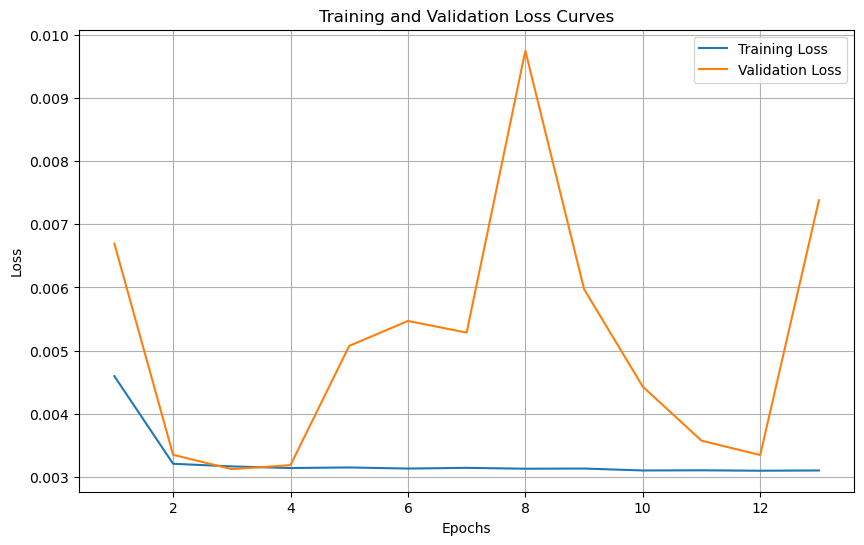

In [15]:
# Plot training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)

# Interpretability

In [16]:
alpha = {}
alpha_std = {}
for i in f_test.keys():
    if i==0:
        alpha_bias = (f_test[0] * c_test[0]).mean(0)  # Mean of bias alpha coefficients
        alpha_bias_std = (f_test[0] * c_test[0]).std(0)  # Std of bias alpha coefficients
    else:
        alpha[i] = (f_test[i] * c_test[i]).mean(0)  # Mean of regularn alpha coefficients
        alpha_std[i] = (f_test[i] * c_test[i]).std(0)  # Std of regularn alpha coefficients

In [17]:
# Compute beta_tilde_tmp, beta_tilde, and beta_tilde_std using NumPy
beta_tilde_tmp = np.abs(f_test[1] * c_test[1]).sum(axis=-1)  # sum along the last axis
beta_tilde = beta_tilde_tmp.mean(axis=0)  # mean along the 0th axis
beta_tilde_std = beta_tilde_tmp.std(axis=0)  # std along the 0th axis

# Compute beta and beta_std
beta = beta_tilde / beta_tilde.sum(1,keepdims=True)  # Normalize beta_tilde
beta_std = (beta_tilde_tmp / beta_tilde_tmp.sum(axis=1, keepdims=True)).std(axis=0)  # std after normalization

## $\alpha$ bias

In [18]:
print_bias(alpha_bias, alpha_bias_std, ground_truth_bias)

bias_1 = (0.00086337 ± 0.00000002), gt_bias_1 = 0.00000000
bias_2 = (-0.00102447 ± 0.00000003), gt_bias_2 = 0.00000000


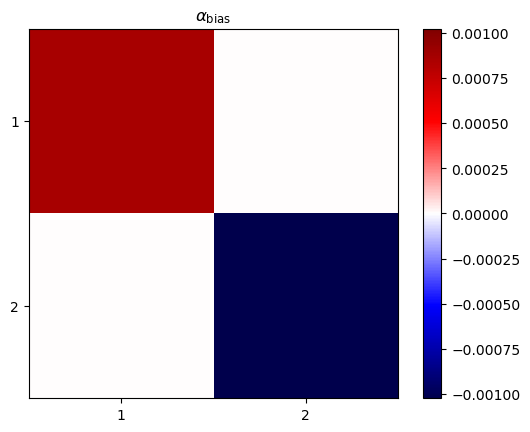

In [19]:
plot_bias(alpha_bias)

## $\alpha$ first order

In [20]:
print_significant_alpha(alpha[1], alpha_std[1],ground_truth_alpha,threshold=0.03)

alpha_112 = (0.055 ± 0.009) Not in ground truth
alpha_117 = (0.055 ± 0.003) Not in ground truth
alpha_119 = (0.035 ± 0.002) Not in ground truth
alpha_122 = (0.32 ± 0.01), gt_alpha_122 = 0.40
alpha_125 = (0.176 ± 0.005), gt_alpha_125 = 0.200
alpha_129 = (0.35 ± 0.01), gt_alpha_129 = 0.40
alpha_211 = (0.045 ± 0.003) Not in ground truth
alpha_212 = (0.34 ± 0.01), gt_alpha_212 = 0.40
alpha_215 = (0.188 ± 0.003), gt_alpha_215 = 0.200
alpha_218 = (-0.038 ± 0.005) Not in ground truth
alpha_219 = (0.345 ± 0.009), gt_alpha_219 = 0.400
alpha_221 = (-0.032 ± 0.006) Not in ground truth
alpha_223 = (0.051 ± 0.007) Not in ground truth
alpha_225 = (0.05 ± 0.01) Not in ground truth


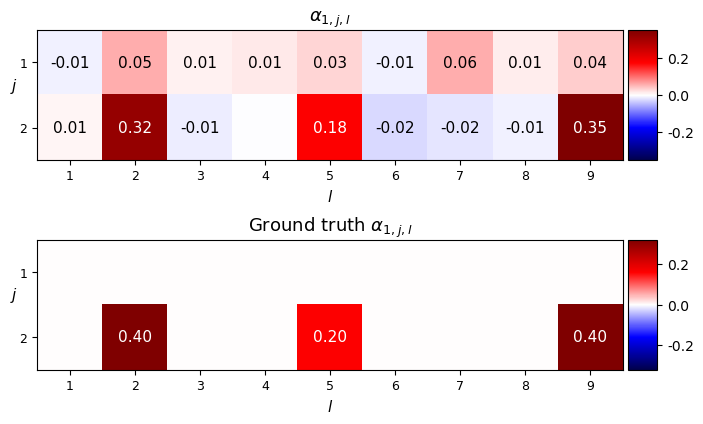

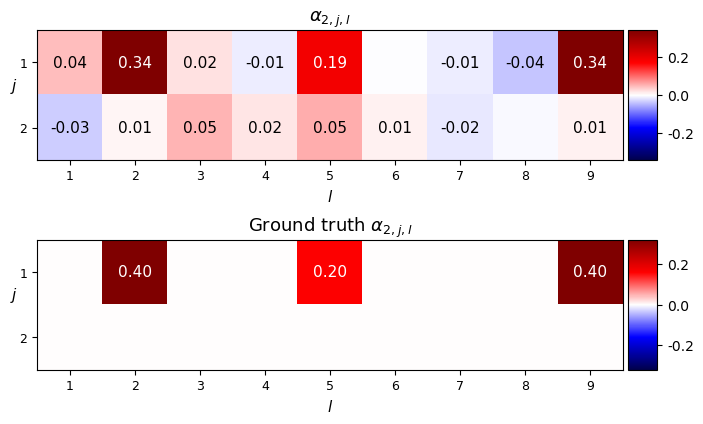

In [21]:
plot_alphas(alpha[1],ground_truth_alpha, figsize=(8, 7), font_size=11, space=-0.65)

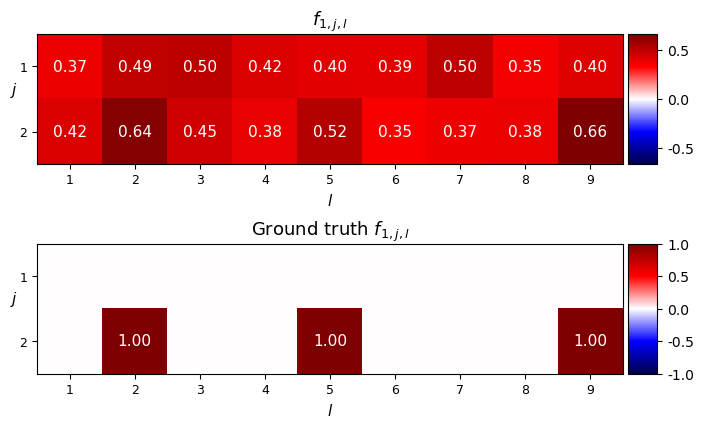

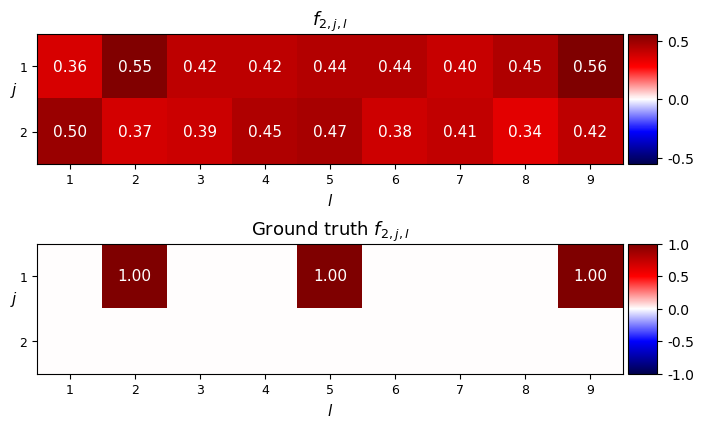

In [22]:
plot_alphas(f_test[1].mean(0),alpha_mask, title=r'f', figsize=(8, 7), font_size=11, space=-0.65)

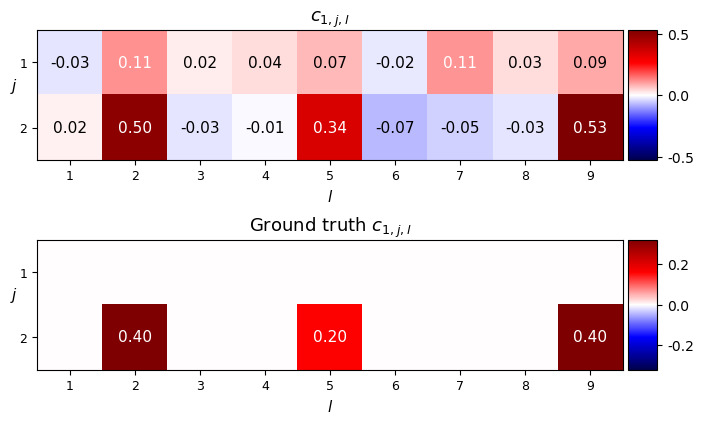

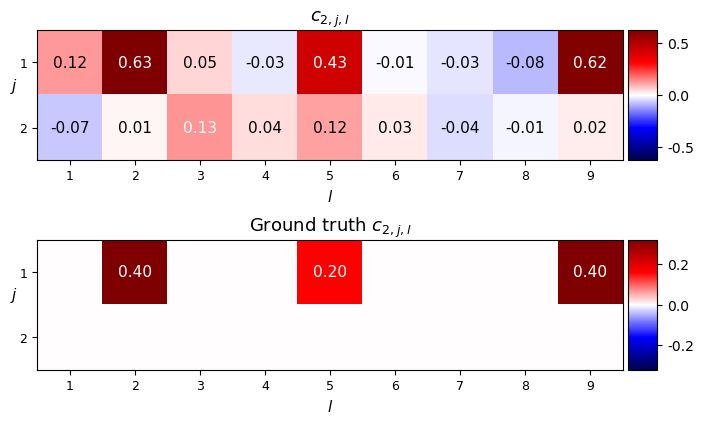

In [23]:
plot_alphas(c_test[1].mean(0),ground_truth_alpha, title=r'c', figsize=(8, 7), font_size=11, space=-0.65)

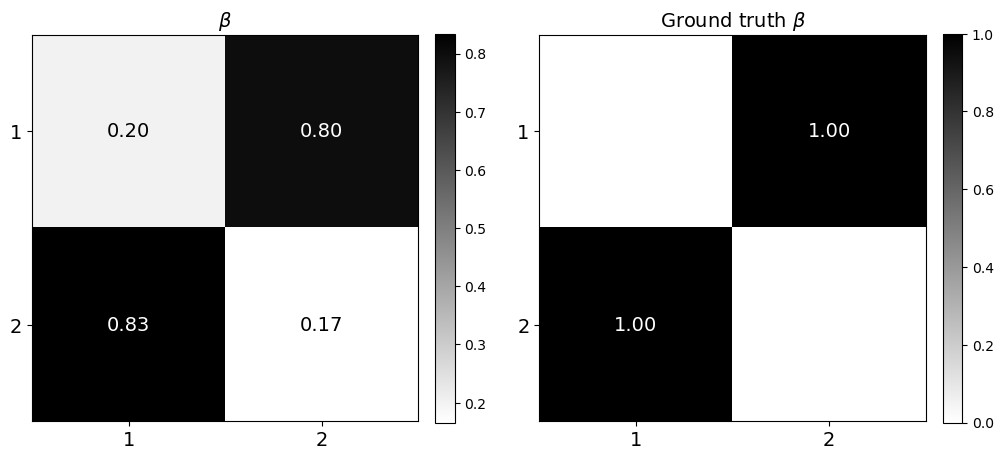

In [24]:
plot_beta(beta,ground_truth_beta)

In [25]:
 print(format_values_with_std(beta, beta_std, round=3))

[[  0.201 ± 0.011   0.799 ± 0.031]
 [  0.834 ± 0.011   0.166 ± 0.031]]


# Optimal window

In [27]:
train_config['verbose'] = False

In [28]:
evaluate_window_sizes(time_series, [5], order=[1,1],config=train_config)

Evaluating window size: 5
Window Size: 5, Test Loss: 0.008116


{5: 0.008115778957145086}

In [29]:
%%time
# Now run the evaluation for window sizes from min_window to max_window
min_window = 3
max_window = 12
window_sizes = list(range(min_window, max_window+1))
test_losses = evaluate_window_sizes(time_series, window_sizes, order=[1,1], config=train_config)

Evaluating window size: 3
Window Size: 3, Test Loss: 0.005039
Evaluating window size: 4
Window Size: 4, Test Loss: 0.004681
Evaluating window size: 5
Window Size: 5, Test Loss: 0.004174
Evaluating window size: 6
Window Size: 6, Test Loss: 0.004173
Evaluating window size: 7
Window Size: 7, Test Loss: 0.004670
Evaluating window size: 8
Window Size: 8, Test Loss: 0.003914
Evaluating window size: 9
Window Size: 9, Test Loss: 0.003324
Evaluating window size: 10
Window Size: 10, Test Loss: 0.003165
Evaluating window size: 11
Window Size: 11, Test Loss: 0.003139
Evaluating window size: 12
Window Size: 12, Test Loss: 0.003148
CPU times: user 7min 22s, sys: 1.1 s, total: 7min 23s
Wall time: 7min 25s


In [30]:
# Find the window size with the minimal test loss
optimal_window_size = min(test_losses, key=test_losses.get)

# Print the result
print(f"The optimal window size is {optimal_window_size} with a test loss of {test_losses[optimal_window_size]:.6f}")

The optimal window size is 11 with a test loss of 0.003139


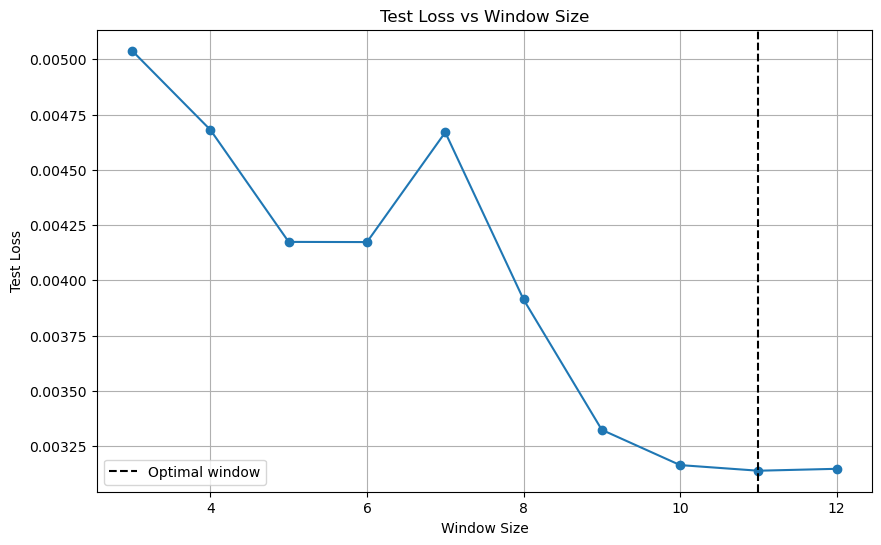

In [31]:
# Plot test losses vs window sizes
plt.figure(figsize=(10, 6))
window_sizes_list = list(test_losses.keys())
test_losses_list = list(test_losses.values())
plt.plot(window_sizes_list, test_losses_list, marker='o')
plt.axvline(optimal_window_size, color='black', linestyle='--', label='Optimal window')
plt.xlabel('Window Size')
plt.ylabel('Test Loss')
plt.title('Test Loss vs Window Size')
plt.grid(True)
plt.legend();

In [32]:
ws_loss = {}
for i in range(5):
    print(f"Run {i+1}")
    
    # Record the start time
    start_time = time.time()
    
    # Evaluate window sizes with verbose set to False
    test_losses = evaluate_window_sizes(time_series, window_sizes, order=[1, 1], config=train_config, verbose=False)
    
    # Record the end time
    end_time = time.time()
    
    # Store the test losses
    ws_loss[i] = test_losses
    
    # Find the window size with the minimal test loss
    optimal_window_size = min(test_losses, key=test_losses.get)
    
    # Print the result
    print(f"The optimal window size is {optimal_window_size} with a test loss of {test_losses[optimal_window_size]:.6f}")
    
    # Calculate and print the elapsed time
    elapsed_time = end_time - start_time
    print(f"Time taken for Run {i+1}: {elapsed_time:.2f} seconds")

Run 1
The optimal window size is 10 with a test loss of 0.003163
Time taken for Run 1: 566.23 seconds
Run 2
The optimal window size is 10 with a test loss of 0.003219
Time taken for Run 2: 481.66 seconds
Run 3
The optimal window size is 9 with a test loss of 0.003550
Time taken for Run 3: 371.37 seconds
Run 4
The optimal window size is 10 with a test loss of 0.004055
Time taken for Run 4: 370.27 seconds
Run 5
The optimal window size is 10 with a test loss of 0.003283
Time taken for Run 5: 425.27 seconds


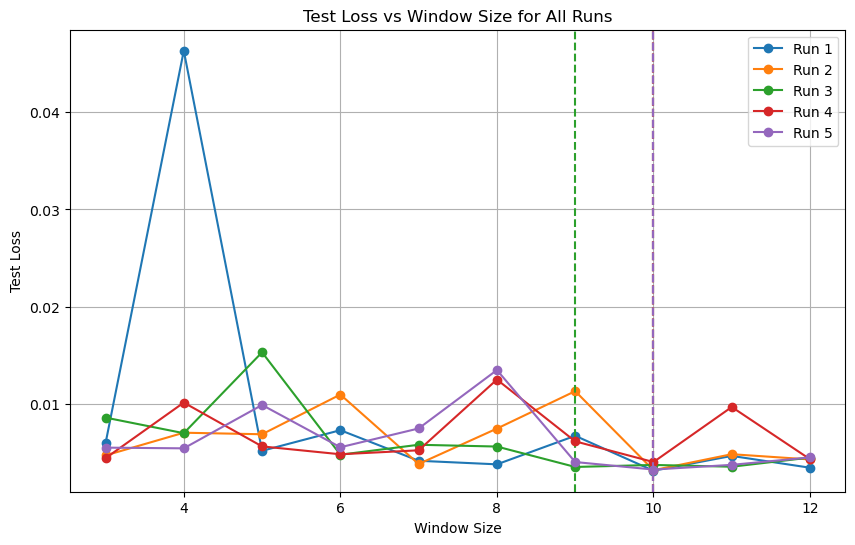

In [33]:
plt.figure(figsize=(10, 6))

# Iterate over all runs
for i, (key, losses) in enumerate(ws_loss.items()):
    # Extract window sizes and corresponding test losses
    window_sizes_list = list(losses.keys())
    test_losses_list = list(losses.values())
    
    # Plot the test losses for the current run
    line, = plt.plot(window_sizes_list, test_losses_list, marker='o', label=f"Run {key + 1}")
    
    # Use the same color for the vertical line
    optimal_window = min(losses, key=losses.get)
    plt.axvline(optimal_window, color=line.get_color(), linestyle='--')

# Add labels, title, and legend
plt.xlabel('Window Size')
plt.ylabel('Test Loss')
plt.title('Test Loss vs Window Size for All Runs')
plt.grid(True)
plt.legend()  # Place legend automatically to avoid overlap
plt.show()

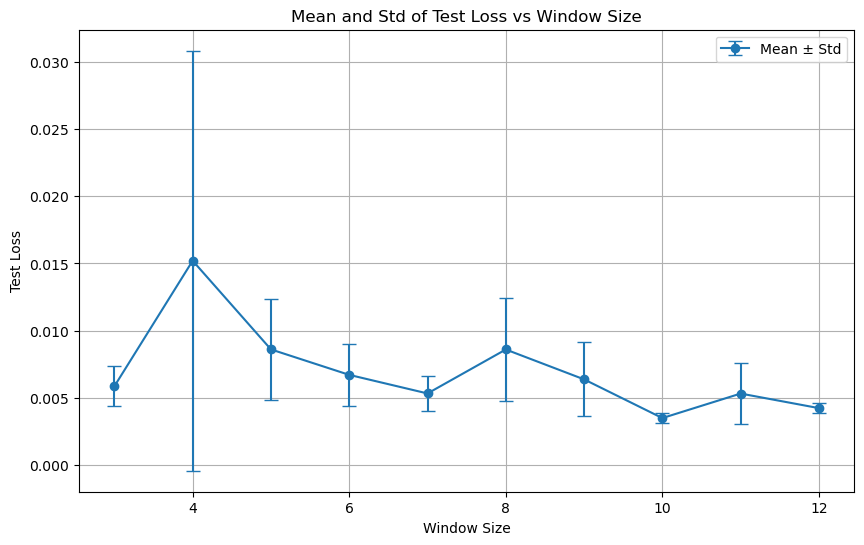

In [34]:
# Extract window sizes and test losses
window_sizes = list(next(iter(ws_loss.values())).keys())  # Assuming all runs have the same window sizes
losses_matrix = np.array([list(losses.values()) for losses in ws_loss.values()])

# Calculate mean and std along the runs axis
mean_losses = np.mean(losses_matrix, axis=0)
std_losses = np.std(losses_matrix, axis=0)

# Create the error bar plot
plt.figure(figsize=(10, 6))
plt.errorbar(window_sizes, mean_losses, yerr=std_losses, fmt='o-', capsize=5, label='Mean ± Std')

# Add labels, title, and legend
plt.xlabel('Window Size')
plt.ylabel('Test Loss')
plt.title('Mean and Std of Test Loss vs Window Size')
plt.grid(True)
plt.legend()
plt.show()

# Test stabitliy on multiple runs

In [26]:
# Do not print train/eval output
train_config['verbose'] = False

# Collect results from multiple runs
results = collect_multiple_runs(
    n_runs=5,
    time_series=time_series,
    window_size=10,
    temperature=1.0,
    order=[1,1],
    config=train_config,
    verbose=True
)

Training Configuration:
  verbose: False
  device: cuda:0
  learning_rate: 0.001
  scheduler_patience: 5
  early_stopping_modifier: 2
  criterion: MSELoss()
Starting Run 1/5
Run 1 completed. Test Loss: 3.309739e-03
Starting Run 2/5
Run 2 completed. Test Loss: 3.163370e-03
Starting Run 3/5
Run 3 completed. Test Loss: 9.033546e-03
Starting Run 4/5
Run 4 completed. Test Loss: 4.287316e-03
Starting Run 5/5
Run 5 completed. Test Loss: 4.868192e-03
Time taken for Run 2: 48.65 seconds


In [27]:
stats = calculate_multiple_run_statistics(results)

In [28]:
stats.keys()

dict_keys(['alpha', 'alpha_bias', 'beta', 'f', 'c'])

In [29]:
print_bias(stats['alpha_bias']['mean'],stats['alpha_bias']['std'], ground_truth_bias)

bias_1 = (-0.0015 ± 0.0007), gt_bias_1 = 0.0000
bias_2 = (-0.0015 ± 0.0008), gt_bias_2 = 0.0000


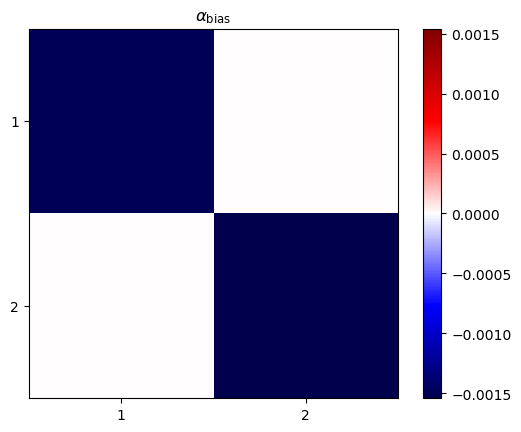

In [30]:
plot_bias(stats['alpha_bias']['mean'])

In [31]:
print_significant_alpha(stats['alpha'][1]['mean'], stats['alpha'][1]['std'],ground_truth_alpha, threshold=0.01)

alpha_114 = (0.023 ± 0.004) Not in ground truth
alpha_122 = (0.37 ± 0.01), gt_alpha_122 = 0.40
alpha_124 = (0.015 ± 0.004) Not in ground truth
alpha_125 = (0.19 ± 0.02), gt_alpha_125 = 0.20
alpha_129 = (0.39 ± 0.02), gt_alpha_129 = 0.40
alpha_1210 = (-0.014 ± 0.004) Not in ground truth
alpha_212 = (0.35 ± 0.03), gt_alpha_212 = 0.40
alpha_215 = (0.16 ± 0.02), gt_alpha_215 = 0.20
alpha_219 = (0.42 ± 0.02), gt_alpha_219 = 0.40


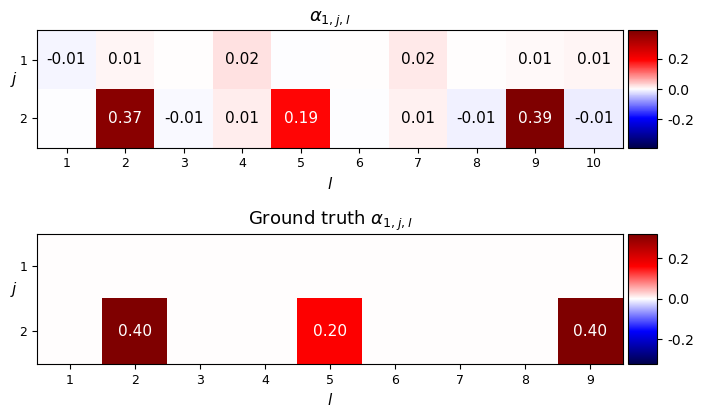

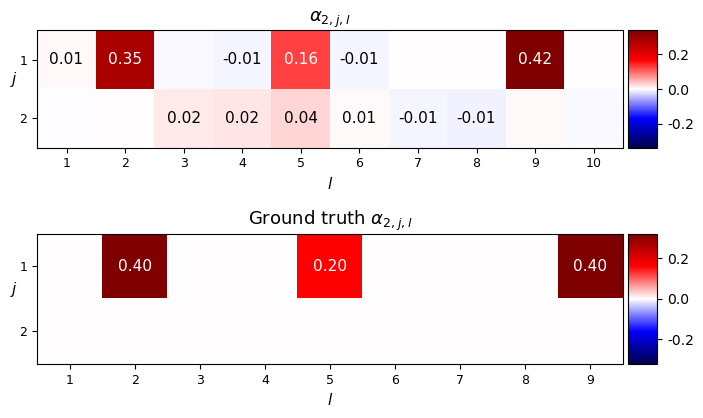

In [32]:
plot_alphas(stats['alpha'][1]['mean'],ground_truth_alpha, figsize=(8, 7), font_size=11, space=-0.65)

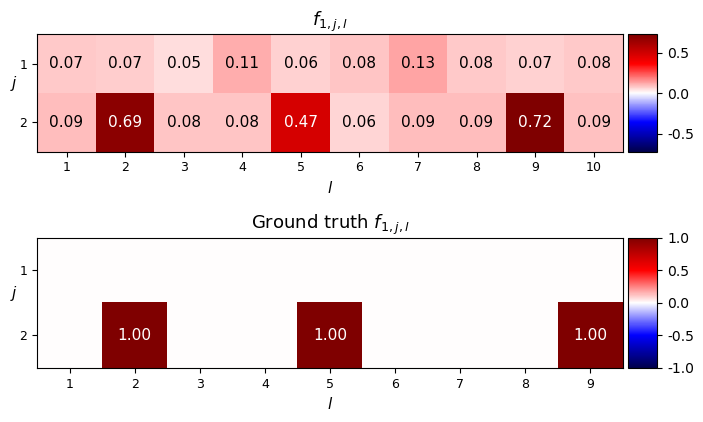

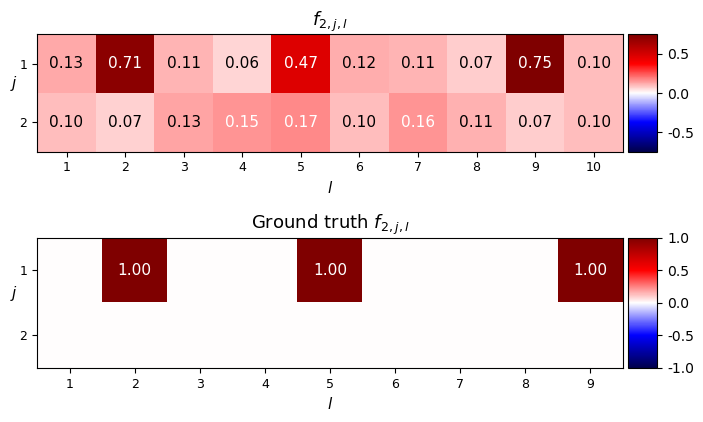

In [33]:
plot_alphas(stats['f'][1]['mean'],alpha_mask, figsize=(8, 7), title=r'f', font_size=11, space=-0.65)

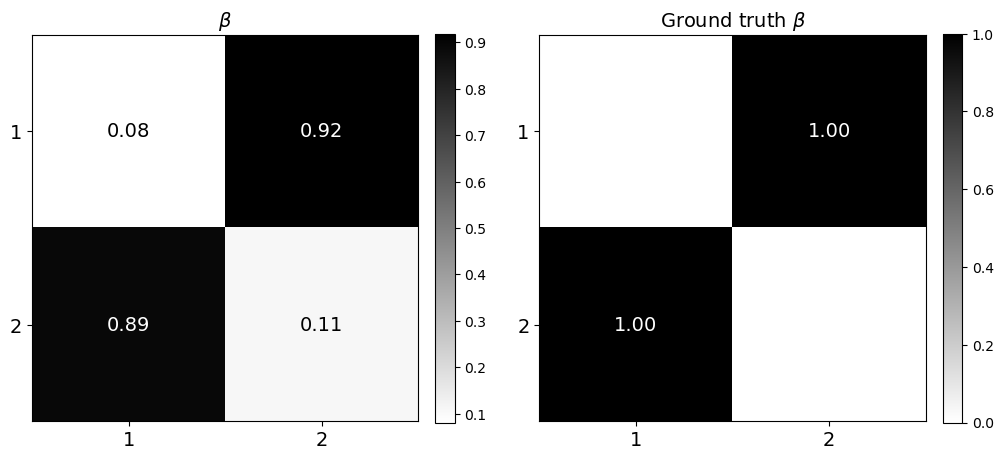

In [34]:
plot_beta(stats['beta'][1]['mean'],ground_truth_beta)

In [35]:
print("beta")
print(format_values_with_std(stats['beta'][1]['mean'], stats['beta'][1]['std'], round=2))

beta
[[  0.08 ± 0.01   0.92 ± 0.01]
 [  0.89 ± 0.03   0.11 ± 0.03]]
